# MNIST with CNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

## Load Dataset

In [3]:
transform = transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root="/Dataset", train=True, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 105172158.74it/s]


Extracting /Dataset/MNIST/raw/train-images-idx3-ubyte.gz to /Dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 79904811.23it/s]


Extracting /Dataset/MNIST/raw/train-labels-idx1-ubyte.gz to /Dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26544349.63it/s]


Extracting /Dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to /Dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3378352.33it/s]


Extracting /Dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Dataset/MNIST/raw



In [5]:
test_data = datasets.MNIST(root="/Dataset", train=False, download=True, transform=transform)

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /Dataset
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /Dataset
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)

In [9]:
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

## Define Model

In [10]:
# 1 COLOR CHANNE, 6 FILTERS (OUTPUT CHANNELS), 3*3 KERNEL, STRIDE=1
conv1 = nn.Conv2d(1,6,3,1)   # ----> 6 filters, ---> pooling ---> conv2

# 6 Input Filters Conv1, 16 filters, 3*3, stride=1
conv2 = nn.Conv2d(6,16,3,1)

In [11]:
# First batch
for b,(X_train, y_train) in enumerate(train_data):
  break

In [12]:
X_train.shape

torch.Size([1, 28, 28])

In [13]:
y_train

5

In [14]:
x = X_train.view(1,1,28,28)  # ----> 4d batch (batch of 1 image)

In [15]:
x = F.relu(conv1(x))

In [16]:
x.shape

torch.Size([1, 6, 26, 26])

In [17]:
x = F.max_pool2d(x,2,2)

In [18]:
x.shape

torch.Size([1, 6, 13, 13])

In [19]:
x = F.relu(conv2(x))

In [20]:
x.shape

torch.Size([1, 16, 11, 11])

In [21]:
x = F.max_pool2d(x,2,2)

In [22]:
x.shape

torch.Size([1, 16, 5, 5])

In [23]:
x.view(-1,16*5*5).shape

torch.Size([1, 400])

In [24]:
x.shape

torch.Size([1, 16, 5, 5])

## Convolutional Neural Network Class

In [25]:
class ConvolutionalNeuralNetwork(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)
    X = X.view(-1, 16*5*5)       # Flatten output
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)



## Create Model

In [26]:
model = ConvolutionalNeuralNetwork()

In [27]:
model

ConvolutionalNeuralNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [28]:
for param in model.parameters():
  print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


## Optimizer

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train Model

In [30]:
import time

start_time = time.time()

# Trackers
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop Epochs
for epoch in range(epochs):

  trn_corr = 0
  tst_corr = 0

  # Train
  for btch,(X_train, y_train) in enumerate(train_loader):

    # b+=1

    y_pred = model(X_train)  # Not Flatten because 2d
    loss = criterion(y_pred, y_train)  # One hot encoded

    predicted = torch.max(y_pred, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    # backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if btch%600 == 0:
      print(f"EPOCH: {epoch+1} BATCH: {btch} LOSS: {loss.item()}")

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad():
    for btch,(X_test, y_test) in enumerate(test_loader):

      y_val = model(X_test)
      # loss = criterion(y_val, y_test) no backward propagation needed

      predicted = torch.max(y_val, 1)[1]
      batch_corr = (predicted == y_test).sum()
      tst_corr += batch_corr

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


current_time = time.time()
total_time = current_time - start_time
print(f"Training took {total_time/60} minutes")

EPOCH: 1 BATCH: 0 LOSS: 2.3049111366271973
EPOCH: 1 BATCH: 600 LOSS: 0.33256787061691284
EPOCH: 1 BATCH: 1200 LOSS: 0.41023820638656616
EPOCH: 1 BATCH: 1800 LOSS: 0.23465153574943542
EPOCH: 1 BATCH: 2400 LOSS: 0.08282827585935593
EPOCH: 1 BATCH: 3000 LOSS: 0.0022935953456908464
EPOCH: 1 BATCH: 3600 LOSS: 0.07156457751989365
EPOCH: 1 BATCH: 4200 LOSS: 0.011699063703417778
EPOCH: 1 BATCH: 4800 LOSS: 0.005803934298455715
EPOCH: 1 BATCH: 5400 LOSS: 0.003200320992618799
EPOCH: 2 BATCH: 0 LOSS: 0.0023459128569811583
EPOCH: 2 BATCH: 600 LOSS: 0.058511167764663696
EPOCH: 2 BATCH: 1200 LOSS: 0.13451078534126282
EPOCH: 2 BATCH: 1800 LOSS: 0.000657163851428777
EPOCH: 2 BATCH: 2400 LOSS: 0.0007287781918421388
EPOCH: 2 BATCH: 3000 LOSS: 0.0041693635284900665
EPOCH: 2 BATCH: 3600 LOSS: 0.003650097642093897
EPOCH: 2 BATCH: 4200 LOSS: 0.014096550643444061
EPOCH: 2 BATCH: 4800 LOSS: 0.001528836553916335
EPOCH: 2 BATCH: 5400 LOSS: 0.027681056410074234
EPOCH: 3 BATCH: 0 LOSS: 0.0008485809084959328
EPOCH:

## Model Evaluation

### LOSS

Text(0.5, 1.0, 'LOSS AT EPOCH')

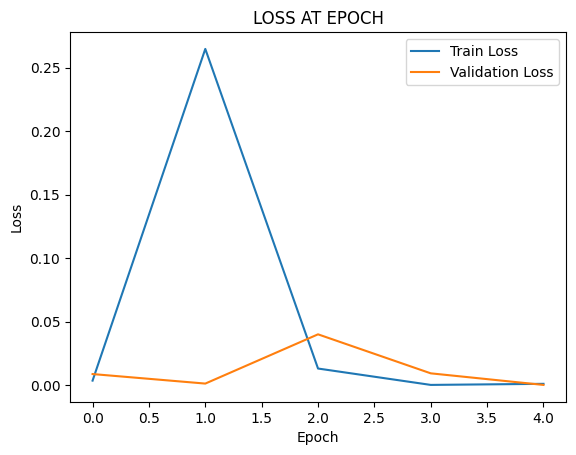

In [43]:
plt.plot(torch.Tensor(train_losses), label="Train Loss")
plt.plot(torch.Tensor(test_losses), label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LOSS AT EPOCH")

## ACCURACY

In [39]:
train_correct

[tensor(56392), tensor(58830), tensor(59158), tensor(59299), tensor(59457)]

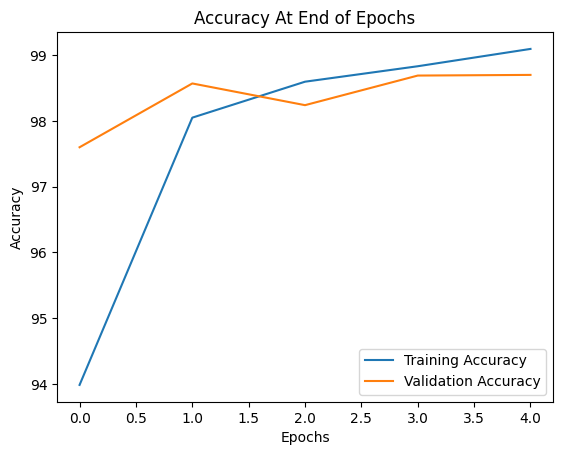

In [44]:
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy At End of Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

## Evaluate All test

In [45]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [46]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_all:
    y_val = model(X_test)
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()

In [47]:
correct.item()

9870

In [48]:
correct.item()/len(X_test)

0.987